In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# code directly from https://github.com/DTrimarchi10/confusion_matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

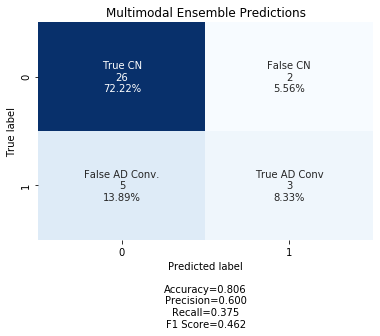

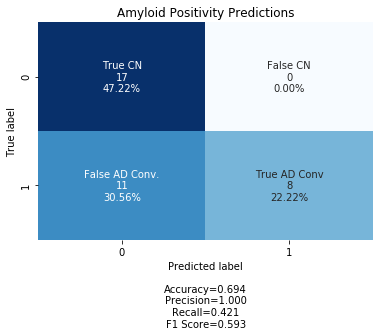

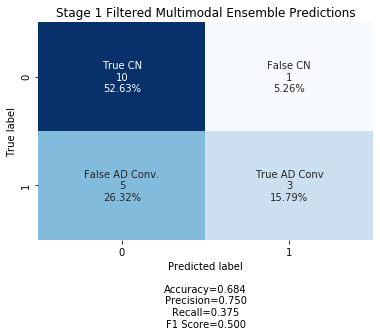

In [21]:
mri_preds = pd.read_csv('C:/Users/Ben/Desktop/ADNI/processed_data/holdout_with_MRI_ensemble.csv')
pet_preds = pd.read_csv('C:/Users/Ben/Desktop/ADNI/processed_data/holdout_with_PET_ensemble.csv')
target = pd.read_csv('C:/Users/Ben/Desktop/ADNI/processed_data/holdout.csv')
patient_preds = pd.DataFrame(np.array(pet_preds['PTID'].unique()), columns = ['PTID'])
mri_score = []
pet_score = []
ad_conv = []
for i in patient_preds['PTID']:
    mri_score.append(np.mean(mri_preds[mri_preds['Subject'] == i]['MRI CNN Prediction']))
    pet_score.append(np.mean(pet_preds[pet_preds['PTID'] == i]['PET CNN Prediction']))
    ad_conv.append(np.mean(target[target['PTID'] == i]['AD_conv']))
    
patient_preds['MRI_Score'] = mri_score
patient_preds['PET_Score'] = pet_score
patient_preds['AD_Conv'] = ad_conv
patient_preds['MRI_PET_Ensemble'] = patient_preds['MRI_Score']  + patient_preds['PET_Score']
patient_preds['MRI_PET_Ensemble'] = (patient_preds['MRI_PET_Ensemble'] >= 1)/1
conf1 = confusion_matrix(patient_preds['AD_Conv'], patient_preds['MRI_PET_Ensemble'])
labels = ['True CN', 'False CN', 'False AD Conv.', 'True AD Conv']
make_confusion_matrix(conf1, group_names = labels, cbar = False, title = 'Multimodal Ensemble Predictions')
plt.savefig('C:/Users/Ben/Desktop/ADNI/figures/Multimodal_Ensemble_Predictions.jpg')
#print(classification_report(patient_preds['AD_Conv'], patient_preds['MRI_PET_Ensemble']))
amyloid = pd.read_csv('C:/Users/Ben/Desktop/ADNI/processed_data/stage1_preds.csv')
#print(classification_report(amyloid['amyloid_pos'], amyloid['AD_conv']))
conf2 = confusion_matrix(amyloid['amyloid_pos'], amyloid['AD_conv'])
make_confusion_matrix(conf2, group_names = labels, cbar = False, title = 'Amyloid Positivity Predictions')
plt.savefig('C:/Users/Ben/Desktop/ADNI/figures/Amyloid_Positivity_Predictions.jpg')
amyloid_merge = amyloid.merge(patient_preds, on = 'PTID')
amyloid_pos = amyloid_merge[amyloid_merge['amyloid_pos'] == 1]
#print(classification_report(amyloid_pos['AD_conv'], amyloid_pos['MRI_PET_Ensemble']))
conf3 = confusion_matrix(amyloid_pos['AD_conv'], amyloid_pos['MRI_PET_Ensemble'])
make_confusion_matrix(conf3, group_names = labels, cbar = False, title = 'Stage 1 Filtered Multimodal Ensemble Predictions')
plt.savefig('C:/Users/Ben/Desktop/ADNI/figures/Filtered_Multimodal_Ensemble_Predictions.jpg')